In [15]:
# 导包
import re
import os

import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

In [16]:
# 训练词向量，
# 这里使用的是北京师范大学中心信息处理研究所与中国人民大学DBIIR实验室的研究者开源的
# "chinese-word-vectors"
# 训练微博词向量.
word_vectors = KeyedVectors.load_word2vec_format('sgns.zhihu.bigram-char.bz2',
                                                binary=False, unicode_errors='ignore')
word_vectors = KeyedVectors.load_word2vec_format('sgns.weibo.bigram-char.bz2', 
                                                 binary=False, unicode_errors='ignore')
# word_vectors = KeyedVectors.load_word2vec_format('merge_sgns_bigram_char300.txt.bz2',
#                                                  binary=False, unicode_errors='ignore')
# word_vectors = KeyedVectors.load_word2vec_format('Tencent_AILab_ChineseEmbedding.txt', binary=False)
# wv_from_text = KeyedVectors.load_word2vec_format('Tencent_AILab_ChineseEmbedding.txt',binary=False)
# word_vectors.save('word_vectors')


In [3]:
word_vectors.most_similar(['女权'])

[('女权主义', 0.7416508197784424),
 ('男权', 0.7347835302352905),
 ('女权主义者', 0.6927400827407837),
 ('狗权', 0.6775093674659729),
 ('婢女', 0.6758884191513062),
 ('重男轻女', 0.6693394184112549),
 ('威权', 0.6632106304168701),
 ('平权', 0.6500369906425476),
 ('男女平等', 0.6472190022468567),
 ('女高', 0.6467345356941223)]

In [17]:
# 读取训练数据
data = pd.read_csv('weibo_senti_100k.csv')
datay = data.iloc[:,0]
datax = data.iloc[:,1]


In [18]:
# 对训练数据进行分词操作
x_tokens = []
for text in datax:
    # 使用jieba进行分词
    cut = jieba.cut(text)
    cut_list = [x for x in cut]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = word_vectors.vocab[word].index
            pass
        except KeyError:
            # 如果不在字典中，则输出0
            cut_list[i] = 0
            pass
        pass
    x_tokens.append(cut_list)
    pass


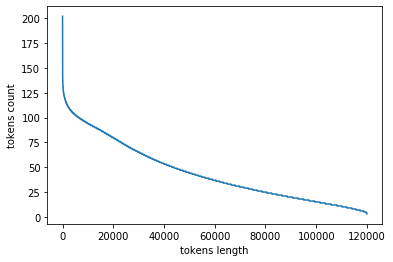

In [19]:
# 索引长度标准化
# 获取每段语句的长度，并画图展示
tokens_count = [len(tokens) for tokens in x_tokens]
tokens_count.sort(reverse=True)
# 画图查看词的长度分布
plt.plot(tokens_count)
plt.ylabel('tokens count')
plt.xlabel('tokens length')
plt.show() 
# 可知大部分词的长度都在125以下

In [20]:
# 当tokens长度分布满足正态分布时
# 可以使用 取tokens的平均值并且加上两个tokens的标准差，来选用tokens的长度
tokens_length = np.mean(tokens_count) + 2 * np.std(tokens_count)
print(tokens_length)

104.02314203699297


In [21]:
# 可知当tokens的长度为104.25191311364534时，大约96%的样本被覆盖
# 我们需要对长度不足的tokens进行padding，超长的进行修剪
np.sum(tokens_count < tokens_length) / len(tokens_count)

0.9649464946494649

In [22]:
# 定义把tokens转换回文本的方法
def reverse_tokens(tokens):
    text = ''
    for index in tokens:
        if index != 0:
            text = text + word_vectors.index2word[index]
        else:
            text = text + ''
        pass
    return text
# 测试
# print(reverse_tokens(x_tokens[0]))
# print(train_y.iloc[0])

In [23]:
# 准备词向量矩阵
embedding_matrix = np.zeros((50000, 300))
for i in range(50000):
    embedding_matrix[i,:] = word_vectors[word_vectors.index2word[i]]
    pass
embedding_matrix = embedding_matrix.astype('float32')
# 检查index是否对应
# 输出300意义为长度为300的embedding向量一一对应
print(np.sum(word_vectors[word_vectors.index2word[300]] == embedding_matrix[300]))

300


In [24]:
# 对训练样本进行padding填充和truncating修剪
x_tokens_pad = tf.keras.preprocessing.sequence.pad_sequences(x_tokens,
                                                            maxlen=int(tokens_length),
                                                            padding='pre',
                                                            truncating='pre')
# 超出五万个词向量的词用0代替
x_tokens_pad[x_tokens_pad >= 50000] = 0
print(x_tokens_pad[33])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0   393     3     0 16386   260     0
    58   175     4    89  2986    92  4260  2347     4 10909     0  9400
     0 12536     4     0   322   322     3     0 16386   260     0    58
    24  8749   125    91    15    89  2986    92]


In [25]:
# 拆分训练集和测试集
x_tokens_train, x_tokens_test, y_train, y_test = train_test_split(x_tokens_pad, datay,
                                                                 test_size=0.1, 
                                                                 random_state=42)

In [26]:
# 构建模型
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(50000, 300,
                            weights=[embedding_matrix],input_length=int(tokens_length),
                            trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')])
model.compile(optimizer='Adam',
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
# 进行训练
# 训练20轮，每轮都进行测试集的验证，使用1%用来测试，每批5399
history = model.fit(x_tokens_train, y_train, batch_size=5399, epochs=20, 
                   validation_split=0.1, validation_freq=1)

Epoch 1/20
19/19 [==============================] - 236s 12s/step - loss: 0.5254 - sparse_categorical_accuracy: 0.7750 - val_loss: 0.3801 - val_sparse_categorical_accuracy: 0.8454
Epoch 2/20
19/19 [==============================] - 215s 11s/step - loss: 0.2992 - sparse_categorical_accuracy: 0.8820 - val_loss: 0.3562 - val_sparse_categorical_accuracy: 0.8575
Epoch 3/20
19/19 [==============================] - 223s 12s/step - loss: 0.2728 - sparse_categorical_accuracy: 0.8932 - val_loss: 0.2050 - val_sparse_categorical_accuracy: 0.9256
Epoch 4/20
19/19 [==============================] - 220s 12s/step - loss: 0.1874 - sparse_categorical_accuracy: 0.9299 - val_loss: 0.1661 - val_sparse_categorical_accuracy: 0.9379
Epoch 5/20
19/19 [==============================] - 238s 13s/step - loss: 0.1508 - sparse_categorical_accuracy: 0.9431 - val_loss: 0.1366 - val_sparse_categorical_accuracy: 0.9495
Epoch 6/20
19/19 [==============================] - 224s 12s/step - loss: 0.1226 - sparse_categorica

In [28]:
# 查看网络结构
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 128)          186880    
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 15,198,594
Trainable params: 198,594
Non-trainable params: 15,000,000
_________________________________________________________________


In [29]:
# 使用测试集，验证模型准确率
result = model.evaluate(x_tokens_test, y_test)
print(f'Accuracy:{result[1]}')

375/375 [==============================] - 12s 31ms/step - loss: 0.0524 - sparse_categorical_accuracy: 0.9799
Accuracy:0.9799149632453918


In [31]:
type(history)

tensorflow.python.keras.callbacks.History

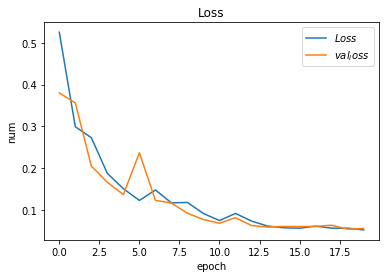

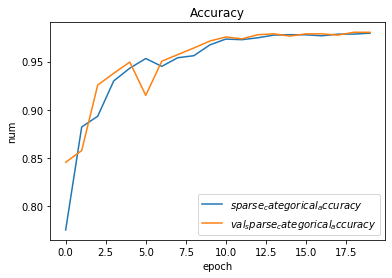

In [32]:
# 画出训练的loss(训练误差)、val_loss(测试误差)和sparse_categorical_accuracy(训练准确度)
# val_sparse_categorical_accuracy(测试准确度)
plt.plot(history.history['loss'],label='$Loss$')
plt.plot(history.history['val_loss'], label='$val_loss$')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('num')
plt.legend()
plt.show()
plt.plot(history.history['sparse_categorical_accuracy'], label='$sparse_categorical_accuracy$')
plt.plot(history.history['val_sparse_categorical_accuracy'],label='$val_sparse_categorical_accuracy$')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('num')
plt.legend()
plt.show()

In [37]:
# 用训练好的模型对文本进行测试
def predict_sentiment(text):
    print(text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [x for x in cut]
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = word_vectors.vocab[word].index
        except KeyError:
            cut_list[i] = 0
        pass
    # padding
    tokens_pad = tf.keras.preprocessing.sequence.pad_sequences([cut_list], 
                                                              maxlen=int(tokens_length),
                                                              padding='pre',
                                                              truncating='pre')
    # 大于50000的归0，不归0模型的使用会报错
    tokens_pad[tokens_pad >= 50000] = 0
    return tokens_pad
test_list = [
    '支持中国加入，进入圈里才好说话办事',
    '这护士是瞎子吗 这都能错',
    '呕呕呕',
    '你想错了，不要质疑，他就是这么贱',
    '酒店设施不是新的，服务态度很不好',
    '酒店卫生条件非常不好',
    '床铺非常舒适',
    '房间很冷，还不给开暖气',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生,心情不好',
    '因为过节所以要我临时加钱，比团购的价格贵',
    '房间很温馨，前台服务很好,'
]
for text in test_list:
    try:
        tokens_pad = predict_sentiment(text)
        result = model.predict(x=tokens_pad)
        print(result)
        if result[0][0] <= result[0][1]:
            print(f'正：{result[0][1]}')
        else:
            print(f'负：{result[0][0]}')
    except Exception as ex:
        print(ex.args)
        pass
    pass

支持中国加入，进入圈里才好说话办事
[[0.18108441 0.8189156 ]]
正：0.818915605545044
这护士是瞎子吗 这都能错
[[0.6683997 0.3316003]]
负：0.6683996915817261
呕呕呕
[[0.6119784  0.38802168]]
负：0.6119784116744995
你想错了，不要质疑，他就是这么贱
[[0.58040786 0.41959214]]
负：0.5804078578948975
酒店设施不是新的，服务态度很不好
[[0.5597047 0.4402953]]
负：0.5597047209739685
酒店卫生条件非常不好
[[0.5227245 0.4772755]]
负：0.5227245092391968
床铺非常舒适
[[0.34996772 0.6500323 ]]
正：0.6500322818756104
房间很冷，还不给开暖气
[[0.51045203 0.48954797]]
负：0.5104520320892334
房间很凉爽，空调冷气很足
[[0.5807411  0.41925892]]
负：0.5807411074638367
酒店环境不好，住宿体验很不好
[[0.60323834 0.39676166]]
负：0.6032383441925049
房间隔音不到位
[[0.47327125 0.5267288 ]]
正：0.5267288088798523
晚上回来发现没有打扫卫生,心情不好
[[0.72720236 0.27279764]]
负：0.7272023558616638
因为过节所以要我临时加钱，比团购的价格贵
[[0.67473274 0.32526731]]
负：0.6747327446937561
房间很温馨，前台服务很好,
[[0.354445  0.6455549]]
正：0.6455549001693726


In [ ]:
# 使用jieba分词，并将语料分词后追加训练到模型中
filepath = 'yuliao.txt'
file_save_path = 'afteryuliao.txt'

# 打印中文列表
def print_chinese_list(list):
    for i in range(len(list)):
        print(list[i])

# 读取文件内容到列表
file_train_read = []
with open(filepath, 'r', encoding='utf-8') as file_train_row:
    for line in file_train_row: # 按行读取文件
        file_train_read.append(line)
        
# jieba分词后保存在列表中
file_train_seg = []
for i in range(len(file_train_read)):
    file_train_seg.append([''.join(list(jieba.cut(file_train_read[i][9:-11], cut_all = False)))])
    if i % 100 == 0:
        print(i)
        
# 保存分词结果到文件中
with open(file_save_path, 'w', encoding='utf-8') as fw:
    for i in range(len(file_train_read)):
        fw.write(file_train_seg[i][0])
        fw.write('\n')



In [ ]:
import jieba.analyse
fp = open('yuliao.txt', encoding='utf-8', errors='ignore')
new_fp = open('newyuliao.txt','w',encoding='utf-8', errors='ignore')
try:
    all_text = fp.read()
    new_fp.write(all_text)
finally:
    fp.close()
    new_fp.close()
path = 'newyuliao.txt'
file_in = open(path, 'r', encoding='utf-8')
content = file_in.read()
try:
    tags = jieba.analyse.extract_tags(content, topK=100, withWeight=True)
finally:
    file_in.close()
tags

In [15]:
# 读取训练数据
data = pd.read_csv("weibo_senti_100k.csv")
train_x
label = data.iloc[:,0]
datax = data.iloc[:,1]